In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copytree
import os
import matplotlib.pyplot as plt
import cv2
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# to copy the data into folders like we need for the image gen
src=['/kaggle/input/covid19xray/COVID','/kaggle/input/normalxray/NORMALc' , '/kaggle/input/pneumoniag/PNEUMONIA']
dst=['/kaggle/output/working/covid', '/kaggle/output/working/normal' , '/kaggle/output/working/pneumonia']

[ copytree(s, d) for s,d in zip(src , dst)] # copies the directory of the data to other directory

['/kaggle/output/working/covid',
 '/kaggle/output/working/normal',
 '/kaggle/output/working/pneumonia']

In [3]:
os.listdir('/kaggle/output/working/')

['normal', 'covid', 'pneumonia']

In [4]:
data_dir='/kaggle/output/working/'

In [5]:
os.listdir('/kaggle/output/working/covid')

['1102.jpg',
 '217.jpg',
 '195.jpg',
 '224.jpg',
 '1111.jpg',
 '1143.jpg',
 '705.jpg',
 '847.jpg',
 '245.jpg',
 '903.jpg',
 '1013.jpg',
 '515.jpg',
 '367.jpg',
 '725.jpg',
 '1106.jpg',
 '670.jpg',
 '465.jpg',
 '578.jpg',
 '541.jpg',
 '605.jpg',
 '585.jpg',
 '810.jpg',
 '416.jpg',
 '250.jpg',
 '236.jpg',
 '1035.jpg',
 '76.jpg',
 '593.jpg',
 '881.jpg',
 '738.jpg',
 '161.jpg',
 '1026.jpg',
 '506.jpg',
 '80.jpg',
 '1129.jpg',
 '198.jpg',
 '406.jpg',
 '638.jpg',
 '173.jpg',
 '830.jpg',
 '408.jpg',
 '328.jpg',
 '442.jpg',
 '859.jpg',
 '1047.jpg',
 '502.jpg',
 '287.jpg',
 '1011.jpg',
 '180.jpg',
 '571.jpg',
 '947.jpg',
 '936.jpg',
 '529.jpg',
 '431.jpg',
 '496.jpg',
 '263.jpg',
 '1078.jpg',
 '701.jpg',
 '603.jpg',
 '48.jpg',
 '1066.jpg',
 '1144.jpg',
 '132.jpg',
 '189.jpg',
 '539.jpg',
 '309.jpg',
 '632.jpg',
 '812.jpg',
 '877.jpg',
 '674.jpg',
 '814.jpg',
 '226.jpg',
 '114.jpg',
 '905.jpg',
 '508.jpg',
 '1128.jpg',
 '251.jpg',
 '577.jpg',
 '909.jpg',
 '256.jpg',
 '938.jpg',
 '675.jpg',
 '804

In [6]:
classes=['Covid','Normal','Pneumonia']
data_gen=ImageDataGenerator(
                                samplewise_center=True,
                                samplewise_std_normalization=True,
                                rotation_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=0.15,
                                horizontal_flip=True,
                                rescale=1/255.,
                                validation_split=0.1)



train_data=data_gen.flow_from_directory(data_dir,
                                        target_size=(224, 224),
                                        class_mode='categorical',
                                        batch_size=32,
                                        subset="training",
                                        shuffle=True)


val_data=data_gen.flow_from_directory(data_dir,
                                        target_size=(224, 224),
                                        class_mode='categorical',
                                        batch_size=32,
                                        subset="validation",
                                        shuffle=True)

Found 8344 images belonging to 3 classes.
Found 926 images belonging to 3 classes.


In [7]:
# len( next(train_data) )
# len(train_data)
x= train_data.next()
x[0].shape


(32, 224, 224, 3)

In [8]:
from tensorflow.keras.models import Model , load_model
from tensorflow.keras import layers
#from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, RMSprop
import seaborn as sns

In [18]:
def dump_build_model():
  # load the base VGG16 model
  base_model = load_model('../input/chet-xray-encoder-model/encoder_model.h5')
  
  # add a GAP layer
  output = layers.GlobalAveragePooling2D()(base_model.output)

  output = layers.Dense(1028, activation='relu')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(256, activation='relu')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(64, activation='relu')(output)
  output = layers.Dense(3, activation='softmax')(output)

  # set the inputs and outputs of the model
  model = Model( base_model.input , output )

  # freeze the earlier layers and leave the last 4 layers to train
  for layer in base_model.layers[:-2]:
      layer.trainable=False

  # choose the optimizer
  #optimizer = tf.keras.optimizers.RMSprop(0.001)

  # configure the model for training

  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
  
  # display the summary
  model.summary()
  
  return model

In [19]:
model=dump_build_model()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 112, 112, 256)     295168    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 256)      

In [20]:
model.fit(train_data , validation_data=val_data , epochs=20)

Epoch 1/20
261/261 [==============================] - 246s 944ms/step - loss: 0.9418 - accuracy: 0.4970 - val_loss: 0.8017 - val_accuracy: 0.6652
Epoch 2/20
261/261 [==============================] - 240s 919ms/step - loss: 0.7005 - accuracy: 0.6880 - val_loss: 0.5289 - val_accuracy: 0.8110
Epoch 3/20
261/261 [==============================] - 239s 916ms/step - loss: 0.5637 - accuracy: 0.7813 - val_loss: 0.4637 - val_accuracy: 0.8326
Epoch 4/20
261/261 [==============================] - 241s 923ms/step - loss: 0.5266 - accuracy: 0.7928 - val_loss: 0.4620 - val_accuracy: 0.8413
Epoch 5/20
261/261 [==============================] - 247s 945ms/step - loss: 0.4958 - accuracy: 0.8140 - val_loss: 0.4742 - val_accuracy: 0.8359
Epoch 6/20
261/261 [==============================] - 256s 981ms/step - loss: 0.4840 - accuracy: 0.8151 - val_loss: 0.4076 - val_accuracy: 0.8499
Epoch 7/20
261/261 [==============================] - 251s 960ms/step - loss: 0.4558 - accuracy: 0.8302 - val_loss: 0.4437 -

## As we can see the model performs poorly because it's training on much less data, with more than 7mil parameter, so in the next model we will try reducing the num of trained params 

(0.0, 1.0)

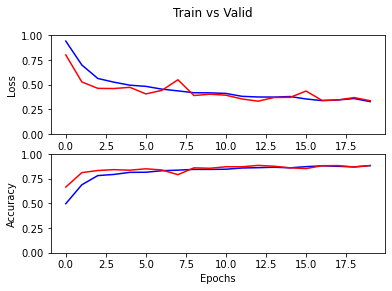

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1)

fig.suptitle('Train vs Valid')

ax1.plot(range(20), model.history.history['loss'],color='b', label='loss')
ax1.plot(range(20), model.history.history['val_loss'],color='r', label='val_loss')
ax1.set_ylabel('Loss')


ax2.plot(range(20), model.history.history['accuracy'], label='accuracy')
ax2.plot(range(20), model.history.history['val_accuracy'], label='val_accuracy')
ax2.set_ylabel('Accuracy')

ax2.set_xlabel('Epochs')


ax2.set_ylim([0,1])
ax1.set_ylim([0,1])

In [54]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [ layer.output for layer in model.layers] # all layers except the input layer

# Define a new model that generates the above output
#vis_model = Model(model.input , outputs)
vis_model= model
# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append( layer.name.split("/")[0] )

    
print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['input_11_3:0', 'conv2d_122', 'conv2d_123', 'max_pooling2d_30', 'conv2d_124', 'conv2d_125', 'max_pooling2d_31', 'conv2d_126', 'max_pooling2d_32', 'conv2d_127', 'conv2d_128', 'global_average_pooling2d_3', 'dense_6', 'dropout_2', 'dense_7', 'dropout_3', 'dense_8', 'dense_9']


In [76]:
def get_CAM(processed_image, actual_label, layer_name='conv2d_127'):
    model_grad = Model( [model.inputs] ,   [model.get_layer(layer_name).output , model.output]  )
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # watch the conv_output_values
        tape.watch(conv_output_values)

        ## Use binary cross entropy loss
        ## actual_label is 0 if cat, 1 if dog
        # get prediction probability of dog
        # If model does well, 
        # pred_prob should be close to 0 if cat, close to 1 if dog
        pred_prob = predictions[:,1] # [ batch , (cat_prob , dog_prob) ]
        # we tale only one prbability to be able to use binary_crossentropy_loss not sparse_categorical_loss
        
        # make sure actual_label is a float, like the rest of the loss calculation
        actual_label = tf.cast( actual_label , dtype=tf.float32 )
        
        # add a tiny value to avoid log of 0
        smoothing = 0.00001 
        
        # Calculate loss as binary cross entropy
        # we can use tf.keras in that too
        # bce = tf.keras.losses.BinaryCrossentropy()
        # bce(y_true, y_pred).numpy()


        loss = -1 * ( actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing) )
        print(f"binary loss: {loss}")
    
    # get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss , conv_output_values)
    grads_values = tf.keras.backend.mean(grads_values , axis=(0,1,2)) # mean over batch , hight , width --> num of channels
    
    conv_output_values = np.squeeze( conv_output_values.numpy() ) # will remove the 1 valued dimention which is the batch  --> (h , w )
    grads_values = grads_values.numpy()
    print(conv_output_values.shape)
    # weight the convolution outputs with the computed gradients
    for i in range(128): # num of filter channels
        conv_output_values[ : , : , i ] *= grads_values[i] # multiply the gradient of the channels by the channels values
    heatmap = np.mean(conv_output_values, axis=-1)# taking the mean over the channels , --> ( h , w )
    
    heatmap = np.maximum(heatmap, 0) # taking only the positive values
    heatmap /= heatmap.max()# regularizing the pixel values
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [ ]:
#next(train_data)[0].shape

In [56]:
idx_class={idx : label for idx,label in enumerate(classes) }
idx_class

{0: 'Covid', 1: 'Normal', 2: 'Pneumonia'}

In [82]:
def show_sample():
    

    images, labels= next(val_data)
    sample_image = images[0]  # batch 0 so that returns ( h , w , c) for the image, without the batch dimention
    sample_label = labels[0] # takes batch of xs and ys # x= train_data.next() -> x[0].shape -> 32,224,224,3
    
    sample_image_processed = np.expand_dims(sample_image, axis=0) # adding back the batch dimention
    
    activations = vis_model.predict(sample_image_processed) # the output of each layer -features-
    
    pred_label = np.argmax( model.predict(sample_image_processed) , axis=-1 )[0]
    pred_label = idx_class[pred_label]
    
    print(activations[0].shape)
    sample_activation = activations[0] [0 , : , : , -1] # taking the first output , for image of batch 0, and for the last layer #16 , --> (h,w)
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip( sample_activation , 0 , 255 ).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed , sample_label )
    heatmap = cv2.resize( heatmap, ( sample_image.shape[0], sample_image.shape[1 ]) )
    heatmap = heatmap *255
    heatmap = np.clip( heatmap , 0 , 255 ).astype(np.uint8)
    heatmap = cv2.applyColorMap( heatmap , cv2.COLORMAP_HOT )
    converted_img = sample_image
    super_imposed_image = cv2.addWeighted( converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0 )
    
    sample_label = idx_class[np.argmax(sample_label)]
    
    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

(1, 224, 224, 32)
binary loss: [0.02060455 0.02060455 3.8915458 ]
(28, 28, 1024)


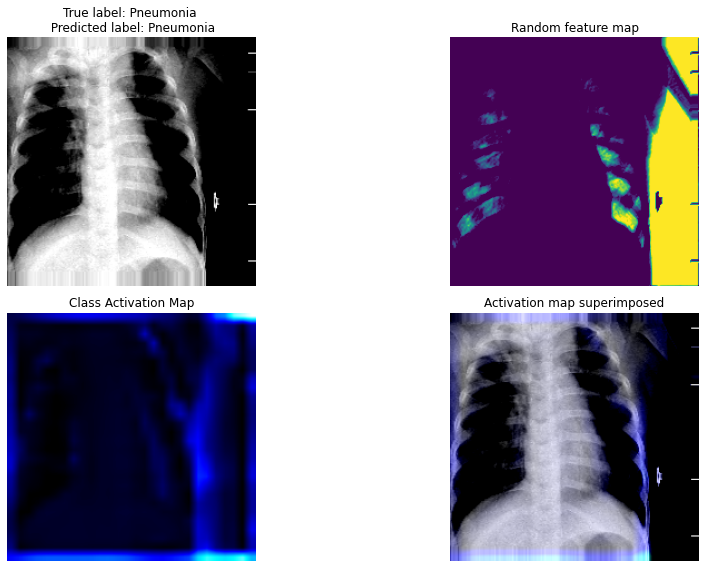

In [93]:
# Choose an image index to show, or leave it as None to get a random image
activations = show_sample()

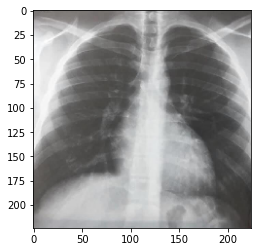

In [94]:
from tensorflow.keras.preprocessing import image
#2- setting the path of the image
path='../input/nawwar/1.jpeg'
#3- uploading the image into a variable

img= image.load_img( path , target_size=( 224,224 ) )
# don't forget the target size the model is expecting
#4- processing the image variable to suit the model

x= image.img_to_array( img )
x= np.expand_dims( x , axis=0 )
images= np.vstack( [x] )
 
plt.imshow(img) # to show the image

In [95]:
# to predict the image
idx_class[np.argmax(model.predict(x))]

'Covid'